In [9]:
# import ipyparallel as ipp
# rc = ipp.Client()
# rc.ids

In [2]:
import xarray as xr
import numpy as np
import gsw
import oocgcm.griddeddata as GriddedData
from dask.diagnostics import ProgressBar
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/mnt/meom/workdir/dewarw/eSM60-BLBT02-S/'
sdir = '/scratch/dewardom/'

In [4]:
g = 9.81
ys,ye = (198,402)
xs,xe = (1168,1372)

dsmask = xr.open_dataset(op.join(ddir,'../mask.nc'))
At = (dsmask.e1t * dsmask.e2t)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
dsmask
# %pxresult

<xarray.Dataset>
Dimensions:       (t: 1, x: 2170, y: 887, z: 300)
Dimensions without coordinates: t, x, y, z
Data variables:
    e3t_0         (t, z, y, x) float64 ...
    e3t_1d        (t, z) float64 ...
    e3u_0         (t, z, y, x) float64 ...
    e3v_0         (t, z, y, x) float64 ...
    e3w_0         (t, z, y, x) float64 ...
    e3w_1d        (t, z) float64 ...
    gdept_0       (t, z, y, x) float32 ...
    gdept_1d      (t, z) float64 ...
    gdepu         (t, z, y, x) float32 ...
    gdepv         (t, z, y, x) float32 ...
    gdepw_0       (t, z, y, x) float32 ...
    gdepw_1d      (t, z) float64 ...
    isfdraft      (t, y, x) float32 ...
    mbathy        (t, y, x) int16 ...
    misf          (t, y, x) int16 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    nav_lon       (y, x) float32 ...
    time_counter  (t) float64 ...
    fmask         (t, z, y, x) int8 ...
    fmaskutil     (t, y, x) int8 ...
    tmask         (t, z, y, x) int8 ...
    tma

In [5]:
cori = gsw.f(dsmask.nav_lat.sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2)))
fb = ((cori*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
      / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     )
cori.shape

(200, 200)

# March 1, 2010

In [5]:
dst = xr.open_dataset(op.join(ddir,'eSM60-BLBT02_y2010m03d01.1h_gridT.nc'))
dss = xr.open_dataset(op.join(ddir,'eSM60-BLBT02_y2010m03d01.1h_gridS.nc'))
dst

<xarray.Dataset>
Dimensions:       (deptht: 81, time_counter: 24, x: 2170, y: 887)
Coordinates:
  * deptht        (deptht) float32 0.48045477 1.5587916 ... 586.00415 599.69586
  * time_counter  (time_counter) datetime64[ns] 2010-03-01T00:30:00 ... 2010-03-01T23:30:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    votemper      (time_counter, deptht, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           cdfclip -f /store/lbrodeau/eNATL60/ORGANIZED/eNATL60-B...

In [6]:
CT = dst.votemper[0].sel(y=slice(ys,ye),x=slice(xs,xe)).load()
SA = dss.vosaline[0].sel(y=slice(ys,ye),x=slice(xs,xe)).load()

In [7]:
rho = xr.DataArray(1e3 + gsw.density.sigma0(SA.data, CT.data),
                  dims=SA.dims, coords=SA.coords
                  )
buoy = -g*(rho-1e3)*1e-3

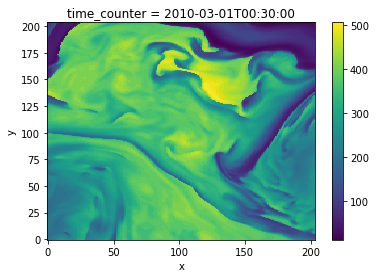

In [10]:
nMLD = np.argmin(np.abs((rho-rho[0])-0.03), axis=0)
MLD = xr.DataArray(np.ones_like(rho[0])[np.newaxis,:,:]*rho.deptht.data[:,np.newaxis,np.newaxis],
                  dims=rho.dims, coords=rho.coords).isel(deptht=nMLD)
MLD.plot()

In [9]:
dsw = xr.open_dataset(op.join(ddir,'eSM60-BLBT02_y2010m03d01.1h_gridW.nc'))
dsw

<xarray.Dataset>
Dimensions:       (depthw: 81, time_counter: 24, x: 2170, y: 887)
Coordinates:
  * depthw        (depthw) float32 0.0 1.0000261 2.156828 ... 579.2115 592.83234
  * time_counter  (time_counter) datetime64[ns] 2010-03-01T00:30:00 ... 2010-03-01T23:30:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    vovecrtz      (time_counter, depthw, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           cdfclip -f /store/lbrodeau/eNATL60/ORGANIZED/eNATL60-B...

In [16]:
w = dsw.vovecrtz[0].sel(y=slice(ys,ye),x=slice(xs,xe)).load()

In [14]:
sst = dst.votemper[:,0].load()
sst

<xarray.DataArray 'votemper' (time_counter: 24, y: 887, x: 2170)>
array([[[14.925472 , 15.089767 , 15.230107 , ..., 17.416203 ,
         17.415342 , 17.414865 ],
        [14.647514 , 14.832066 , 14.997056 , ..., 17.43284  ,
         17.431892 , 17.431152 ],
        [14.346254 , 14.548493 , 14.745539 , ..., 17.446218 ,
         17.445421 , 17.44474  ],
        ...,
        [       nan,        nan,        nan, ..., 14.663776 ,
         14.61351  , 14.617476 ],
        [       nan,        nan,        nan, ..., 14.631523 ,
         14.589698 , 14.602689 ],
        [       nan,        nan,        nan, ..., 14.603018 ,
         14.572015 , 14.595714 ]],

       [[14.842284 , 15.012395 , 15.157034 , ..., 17.406504 ,
         17.405806 , 17.405474 ],
        [14.565101 , 14.750793 , 14.919733 , ..., 17.42368  ,
         17.422823 , 17.422209 ],
        [14.272715 , 14.472459 , 14.664602 , ..., 17.43861  ,
         17.437733 , 17.436954 ],
        ...,
        [       nan,        nan,        na

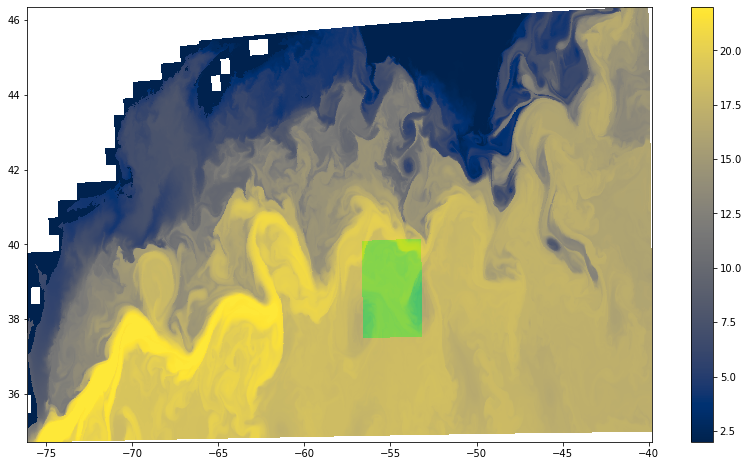

In [15]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
im = ax.pcolor(dst.nav_lon.where(dst.nav_lon!=0.), 
              dst.nav_lat.where(dst.nav_lat!=0.), 
              sst[0],
              cmap='cividis', vmin=2, vmax=22)
ax.pcolor(dst.nav_lon.where(dst.nav_lon!=0.).sel(y=slice(ys,ye),x=slice(xs,xe)), 
         dst.nav_lat.where(dst.nav_lat!=0.).sel(y=slice(ys,ye),x=slice(xs,xe)), 
         sst.sel(y=slice(ys,ye),x=slice(xs,xe))[0],
         cmap='viridis', vmin=2, vmax=22)
cbar = fig.colorbar(im)

In [17]:
# xweights = np.repeat(range(26),5)
# yweights = np.repeat(range(24),5)
# sst_chunk = sst.sel(y=slice(ys,ye),x=slice(xs,xe))
# sst_chunk.coords['xw'] = ('x',xweights)
# sst_chunk.coords['yw'] = ('y',yweights)
# sst_chunk

In [11]:
tbt = CT[:,2:-2,2:-2].copy()*np.nan

for j in tbt.y.data:
    for i in range(5):
        temp = ((CT*At)[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At[j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
               )[:,0].compute()
        tbt.sel(y=j)[:,i::5] = temp
tbt

<xarray.DataArray 'votemper' (deptht: 81, y: 200, x: 200)>
array([[[17.04166  , 17.077839 , 17.114864 , ..., 18.17787  ,
         18.167555 , 18.152702 ],
        [17.06035  , 17.087944 , 17.118599 , ..., 18.137863 ,
         18.129253 , 18.112217 ],
        [17.083078 , 17.10377  , 17.128065 , ..., 18.09552  ,
         18.087124 , 18.065504 ],
        ...,
        [19.302324 , 19.338882 , 19.393744 , ..., 18.979927 ,
         18.931051 , 18.881718 ],
        [19.283634 , 19.315828 , 19.359962 , ..., 18.837303 ,
         18.79035  , 18.739374 ],
        [19.265886 , 19.29596  , 19.331959 , ..., 18.688047 ,
         18.642353 , 18.59116  ]],

       [[17.041666 , 17.077845 , 17.114872 , ..., 18.17788  ,
         18.167564 , 18.15271  ],
        [17.060356 , 17.08795  , 17.118605 , ..., 18.13787  ,
         18.129263 , 18.112225 ],
        [17.083084 , 17.103775 , 17.128073 , ..., 18.09553  ,
         18.087133 , 18.065512 ],
        ...,
        [19.302336 , 19.338896 , 19.393757 , ...,

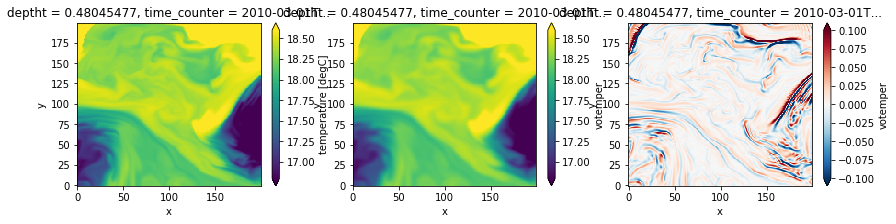

In [12]:
tpt = CT[:,2:-2,2:-2] - tbt

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14,3))
# fig.set_tight_layout(True)
dst.votemper[0,0].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2)).plot(ax=ax1, vmax=18.6, vmin=16.8)
tbt[0].plot(ax=ax2, vmax=18.6, vmin=16.8)
tpt[0].plot(ax=ax3, cmap='RdBu_r', vmax=.1, vmin=-.1)

In [13]:
sbt = SA[:,2:-2,2:-2].copy()*np.nan

for j in sbt.y.data:
    for i in range(5):
        temp = ((SA*At)[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At[j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
               )[:,0].compute()
        sbt.sel(y=j)[:,i::5] = temp
sbt

<xarray.DataArray 'vosaline' (deptht: 81, y: 200, x: 200)>
array([[[36.30803 , 36.313324, 36.31881 , ..., 36.518456, 36.5179  ,
         36.516735],
        [36.310726, 36.314827, 36.319435, ..., 36.513397, 36.513344,
         36.511856],
        [36.314274, 36.317394, 36.32109 , ..., 36.5077  , 36.507893,
         36.505512],
        ...,
        [36.54584 , 36.544785, 36.542892, ..., 36.377747, 36.370895,
         36.364437],
        [36.546093, 36.54557 , 36.54414 , ..., 36.355396, 36.349392,
         36.343437],
        [36.54611 , 36.546043, 36.545174, ..., 36.33414 , 36.32909 ,
         36.32396 ]],

       [[36.30803 , 36.313324, 36.31881 , ..., 36.518456, 36.5179  ,
         36.516735],
        [36.310726, 36.31483 , 36.31944 , ..., 36.513397, 36.513344,
         36.511856],
        [36.314274, 36.317398, 36.32109 , ..., 36.507706, 36.507893,
         36.505512],
        ...,
        [36.54584 , 36.544785, 36.542892, ..., 36.377747, 36.370895,
         36.364437],
        [36.5

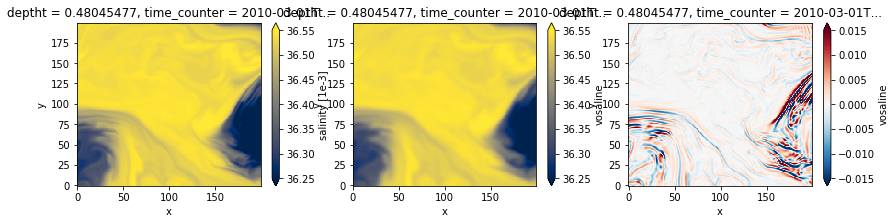

In [14]:
spt = SA[:,2:-2,2:-2] - sbt

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14,3))
# fig.set_tight_layout(True)
dss.vosaline[0,0].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2)).plot(ax=ax1, vmax=36.25, vmin=36.55, cmap='cividis')
sbt[0].plot(ax=ax2, vmax=36.25, vmin=36.55, cmap='cividis')
spt[0].plot(ax=ax3, cmap='RdBu_r', vmax=.015, vmin=-.015)

In [17]:
wbt = w[:,2:-2,2:-2].copy()*np.nan

for j in wbt.y.data:
    for i in range(5):
        temp = ((w*At)[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
                / At[j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
               )[:,0].compute()
        wbt.sel(y=j)[:,i::5] = temp
wbt

<xarray.DataArray 'vovecrtz' (depthw: 81, y: 200, x: 200)>
array([[[-2.4312487e-07, -2.4345036e-07, -2.4374867e-07, ...,
         -1.5564422e-07, -1.5535909e-07, -1.5516193e-07],
        [-2.4266546e-07, -2.4315753e-07, -2.4358593e-07, ...,
         -1.5666234e-07, -1.5638579e-07, -1.5623783e-07],
        [-2.4203013e-07, -2.4265074e-07, -2.4320207e-07, ...,
         -1.5772648e-07, -1.5747416e-07, -1.5739553e-07],
        ...,
        [-1.2796501e-07, -1.2791463e-07, -1.2719151e-07, ...,
         -1.6163396e-07, -1.6188959e-07, -1.6218178e-07],
        [-1.2891783e-07, -1.2907394e-07, -1.2872555e-07, ...,
         -1.6380272e-07, -1.6406311e-07, -1.6442797e-07],
        [-1.2979082e-07, -1.3008386e-07, -1.3004666e-07, ...,
         -1.6618337e-07, -1.6646835e-07, -1.6688260e-07]],

       [[-8.7739772e-06, -7.7496707e-06, -6.5308604e-06, ...,
         -2.2696734e-06, -1.1432157e-06, -3.3858728e-07],
        [-7.4163841e-06, -6.7911428e-06, -5.8116730e-06, ...,
         -2.5297227e-06,

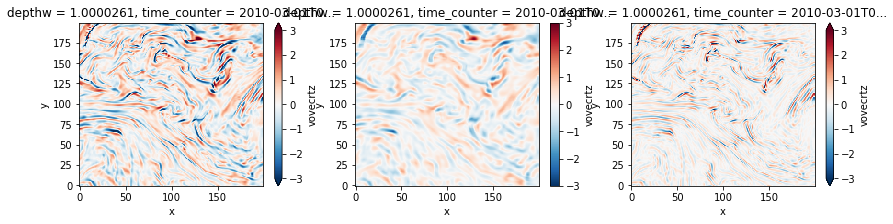

In [18]:
wpt = dsw.vovecrtz[0].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2)) - wbt

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14,3))
# fig.set_tight_layout(True)
(dsw.vovecrtz[0,1]*86400).sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2)).plot(ax=ax1, cmap='RdBu_r', vmax=3, vmin=-3)
(wbt[1]*86400).plot(ax=ax2, cmap='RdBu_r', vmax=3, vmin=-3)
(wpt[1]*86400).plot(ax=ax3, cmap='RdBu_r', vmax=3, vmin=-3)

In [17]:
# # tb.to_dataset(name='tb').to_netcdf('tb_y2010m03d01-00.nc')
# # sb.to_dataset(name='sb').to_netcdf('sb_y2010m03d01-00.nc')
# # wb.to_dataset(name='wb').to_netcdf('wb_y2010m03d01-00.nc')
# tb = xr.open_dataset(op.join(sdir,'tb_y2010m03d01-00.nc')).tb
# sb = xr.open_dataset(op.join(sdir,'sb_y2010m03d01-00.nc')).sb
# wb = xr.open_dataset(op.join(sdir,'wb_y2010m03d01-00.nc')).wb

In [19]:
rhobt = xr.DataArray(1e3 + gsw.density.sigma0(sbt.data, tbt.data),
                    dims=sbt.dims, coords=sbt.coords
                    )
bbt = -g*(rhobt-1e3)*1e-3
bbt

# for j in bb.y.data:
# #     print(j)
#     for i in range(5):
# #         with ProgressBar():
# #             temp = ((dss.vosaline[0]*At).sel(y=slice(ys+j,ys+j+5),x=slice(xs+i,xe)
# #                                             ).chunk({'deptht':4}).coarsen({'y':5,'x':5}, boundary='trim').sum()
# #                     / (At.sel(y=slice(ys+j,ys+j+5),x=slice(xs+i,xe))
# #                       ).coarsen({'y':5,'x':5}, boundary='trim').sum()
# #                    )[:,0].compute()
#         temp = ((buoy*At)[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
#                 / At[j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
#                )[:,0].compute()
#         bb.sel(y=j)[:,i::5] = temp
# bb

<xarray.DataArray (deptht: 81, y: 200, x: 200)>
array([[[-0.25870154, -0.25865541, -0.25860856, ..., -0.25752174,
         -0.25754301, -0.25757094],
        [-0.25867744, -0.25864268, -0.25860436, ..., -0.25758273,
         -0.2576035 , -0.25763435],
        [-0.25865007, -0.25862431, -0.25859424, ..., -0.25764459,
         -0.25766662, -0.25770203],
        ...,
        [-0.2549019 , -0.25480056, -0.25464603, ..., -0.25448044,
         -0.25455323, -0.25462986],
        [-0.25495153, -0.25486536, -0.25474182, ..., -0.25467482,
         -0.25474842, -0.25483226],
        [-0.25499699, -0.25491966, -0.25482116, ..., -0.25489205,
         -0.25496893, -0.25505874]],

       [[-0.25870153, -0.25865539, -0.25860854, ..., -0.25752171,
         -0.25754298, -0.25757092],
        [-0.25867743, -0.25864269, -0.25860438, ..., -0.25758271,
         -0.25760347, -0.25763433],
        [-0.25865006, -0.25862432, -0.25859422, ..., -0.2576446 ,
         -0.25766659, -0.25770201],
        ...,
      

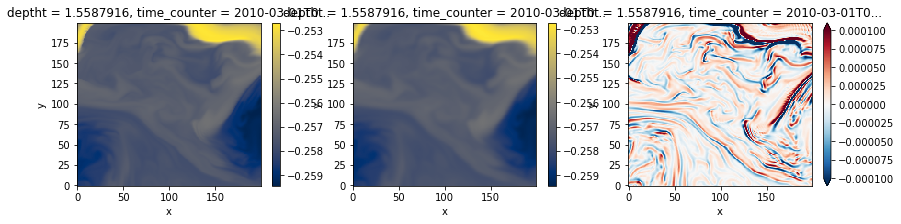

In [20]:
bpt = buoy[:,2:-2,2:-2] - bbt

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14,3))
# fig.set_tight_layout(True)
buoy[1,2:-2,2:-2].plot(ax=ax1, cmap='cividis')
bbt[1].plot(ax=ax2, cmap='cividis')
bpt[1].plot(ax=ax3, cmap='RdBu_r', vmax=1e-4, vmin=-1e-4)

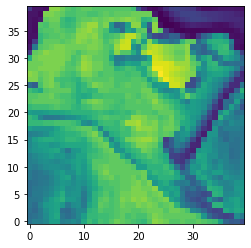

In [31]:
sb = ((SA*At)[:,2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     )
tb = ((CT*At)[:,2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     )
rhob = xr.DataArray(1e3 + gsw.density.sigma0(sb.data, tb.data),
                   dims=sb.dims, coords=sb.coords
                   )
bb = -g*(rhob-1e3)*1e-3
nMLDb = np.argmin(np.abs((rhob-rhob[0])-0.03), axis=0)
MLDb = xr.DataArray(np.ones_like(rhob[0])[np.newaxis,:,:]*rhob.deptht.data[:,np.newaxis,np.newaxis],
                  dims=rhob.dims, coords=rhob.coords).isel(deptht=nMLDb)
plt.imshow(MLDb, origin='bottom')

In [22]:
wpbp = wpt[1:] * .5*(bpt[1:].data+bpt[:-1].data)
wptp = wpt[1:] * .5*(tpt[1:].data+tpt[:-1].data)
wpsp = wpt[1:] * .5*(spt[1:].data+spt[:-1].data)
wpbp

<xarray.DataArray 'vovecrtz' (depthw: 80, y: 200, x: 200)>
array([[[ 2.48240977e-10,  5.10946662e-11,  6.78853598e-12, ...,
         -1.64659846e-11, -1.89685355e-11,  1.32519905e-11],
        [ 2.53114454e-10,  2.75758790e-10,  3.55681153e-10, ...,
          4.04583885e-14,  9.75273749e-12,  7.01011326e-11],
        [-4.37483760e-12,  8.95369799e-12,  8.85321073e-11, ...,
          6.11990005e-12,  3.71482753e-11,  7.74471009e-11],
        ...,
        [ 7.57268417e-11, -2.37207142e-10,  7.25008290e-12, ...,
         -1.73474271e-11, -4.25785756e-11, -1.76518087e-11],
        [ 1.42544755e-10, -5.29839807e-11, -2.73158272e-10, ...,
         -4.99496569e-11, -7.24556760e-11, -3.66536253e-11],
        [ 1.81590899e-10,  8.38659559e-11, -2.08608928e-10, ...,
         -5.41939603e-11, -2.47900583e-11, -1.58278787e-10]],

       [[ 5.34484736e-10,  1.10014918e-10,  1.46607262e-11, ...,
         -3.55811746e-11, -4.07743022e-11,  2.85443795e-11],
        [ 5.45353264e-10,  5.94162117e-10,  

In [49]:
# wpbpb = wpbp[:,2:-2,2:-2].copy()*np.nan
# wptpb = wpbpb.copy()
# wpspb = wpbpb.copy()
# for j in wpbpb.y.data:
#     for i in range(5):
#         temp = ((wpbp*At[2:-2,2:-2])[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
#                 / At[2:-2,2:-2][j:j+5,i:].coarsen({'y':5,'x':5}, 
#                                                   boundary='trim').sum().data
#                )[:,0].compute()
#         wpbpb.sel(y=j)[:,i::5] = temp.data
        
#         temp = ((wptp*At[2:-2,2:-2])[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
#                 / At[2:-2,2:-2][j:j+5,i:].coarsen({'y':5,'x':5}, 
#                                                  boundary='trim').sum().data
#                )[:,0].compute()
#         wptpb.sel(y=j)[:,i::5] = temp.data
                
#         temp = ((wpsp*At[2:-2,2:-2])[:,j:j+5,i:].coarsen({'y':5,'x':5}, boundary='trim').sum()
#                 / At[2:-2,2:-2][j:j+5,i:].coarsen({'y':5,'x':5}, 
#                                                  boundary='trim').sum().data
#                )[:,0].compute()
#         wpspb.sel(y=j)[:,i::5] = temp.data
wpbpb = ((wpbp*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
         / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
        )
wptpb = ((wptp*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
         / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
        )
wpspb = ((wpsp*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
         / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
        )
wpbpb = wpbpb.where(wpbpb.depthw<=MLDb)
wptpb = wptpb.where(wpbpb.depthw<=MLDb)
wpspb = wpspb.where(wpbpb.depthw<=MLDb)
wpbpb

<xarray.DataArray (depthw: 80, y: 40, x: 40)>
array([[[ 2.15216260e-10,  1.25957007e-10,  3.10223951e-10, ...,
         -5.72907463e-13,  5.43857961e-12,  2.87920458e-12],
        [ 4.69783172e-11,  1.22357579e-10,  2.70382144e-10, ...,
          1.28837082e-10,  4.14730387e-11,  2.11220362e-11],
        [ 5.72090534e-11,  1.12851949e-11, -4.66164790e-12, ...,
          3.20722067e-11, -3.96885875e-11,  5.31305066e-12],
        ...,
        [ 2.28812078e-10,  5.57630589e-09,  1.70668099e-08, ...,
          2.62001853e-11,  1.25976426e-11, -3.86114092e-13],
        [ 5.03505000e-10,  5.44335979e-10,  1.42587292e-08, ...,
         -2.12549361e-12,  1.28887023e-11,  1.16638874e-11],
        [ 2.87666853e-10,  2.56209889e-10,  1.33221433e-09, ...,
          2.44034126e-11,  4.17740896e-11, -9.60285705e-12]],

       [[ 4.63684928e-10,  2.71494413e-10,  6.68488274e-10, ...,
         -1.26169165e-12,  1.16816429e-11,  6.14898773e-12],
        [ 1.01174570e-10,  2.63577546e-10,  5.82404730e-1

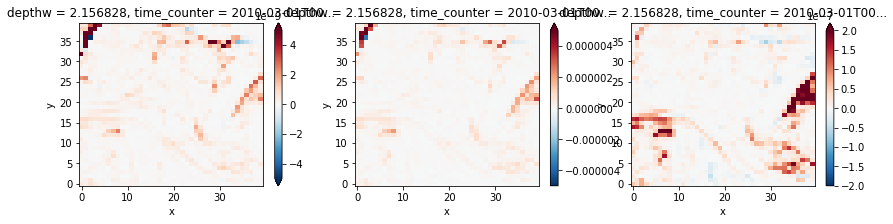

In [41]:
bpt = buoy[:,2:-2,2:-2] - bbt

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14,3))
# fig.set_tight_layout(True)
wpbpb[1].plot(ax=ax1, cmap='RdBu_r', vmax=5e-9)
wptpb[1].plot(ax=ax2, cmap='RdBu_r', vmax=5e-6)
wpspb[1].plot(ax=ax3, cmap='RdBu_r', vmax=2e-7)

Text(0, 0.5, "$\\overline{w's'}^{xy}$ ($\\times 10^{-5}$) [m (g/kg) s$^{-1}$]")

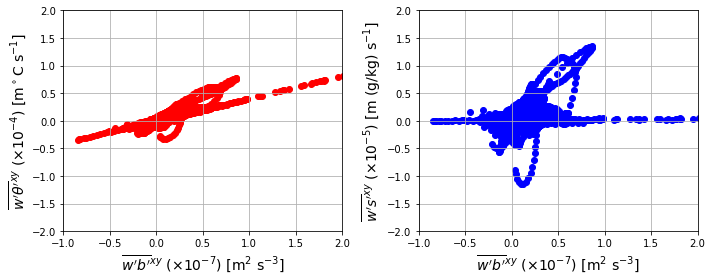

In [50]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.set_tight_layout(True)
ax1.grid(True)
ax2.grid(True)
ax1.scatter(wpbpb.data.ravel()*1e7, wptpb.data.ravel()*1e4, c='r')
ax2.scatter(wpbpb.data.ravel()*1e7, wpspb.data.ravel()*1e5, c='b')
# ax1.set_xscale('log')
# ax2.set_xscale('log')
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_xlim([-1e0,2e0])
ax1.set_ylim([-2e0,2e0])
ax2.set_xlim([-1e0,2e0])
ax2.set_ylim([-2e0,2e0])
ax1.set_xlabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax2.set_xlabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax1.set_ylabel(r"$\overline{w'\theta'}^{xy}$ ($\times 10^{-4}$) [m$^\circ$C s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$\overline{w's'}^{xy}$ ($\times 10^{-5}$) [m (g/kg) s$^{-1}$]", fontsize=14)

In [136]:
# h = dsmask.e3w_0[0,:81].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2))
# dh = dsmask.gdepw_0[0,:81].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2))

# wpbpb_ML = ((wpbpb * dh[1:,2:-2,2:-2].data
#             ).where(xr.DataArray(h[1:,2:-2,2:-2].data, dims=wpbpb.dims, coords=wpbpb.coords)
#                     <= MLDb[2:-2,2:-2]).sum('depthw') * MLDb[2:-2,2:-2]**-1
#             )
# wptpb_ML = ((wptpb * dh[1:,2:-2,2:-2].data
#             ).where(xr.DataArray(h[1:,2:-2,2:-2].data, dims=wptpb.dims, coords=wptpb.coords)
#                     <= MLDb[2:-2,2:-2]).sum('depthw') * MLDb[2:-2,2:-2]**-1
#            )
# wpspb_ML = ((wpspb * dh[1:,2:-2,2:-2].data
#             ).where(xr.DataArray(h[1:,2:-2,2:-2].data, dims=wpspb.dims, coords=wpspb.coords)
#                     <= MLDb[2:-2,2:-2]).sum('depthw') * MLDb[2:-2,2:-2]**-1
#            )
# wpbpb_ML

<xarray.DataArray (y: 112, x: 122)>
array([[ 1.03449614e-07,  6.83916774e-08,  4.85334472e-08, ...,
         4.97099230e-08,  5.74259417e-08,  6.18843902e-08],
       [ 1.07674535e-07,  8.11615983e-08,  6.01794151e-08, ...,
         5.40377776e-08,  5.62825859e-08,  5.73062743e-08],
       [ 1.10644030e-07,  9.96511017e-08,  7.12260379e-08, ...,
         5.00918346e-08,  5.44928975e-08,  5.45807245e-08],
       ...,
       [ 1.34982193e-07,  1.28455047e-07,  1.05376652e-07, ...,
        -6.23857113e-08, -5.69742989e-08, -5.51817091e-08],
       [ 1.31190754e-07,  1.38239212e-07,  1.31043225e-07, ...,
        -5.76130245e-08, -5.42081938e-08, -5.20925260e-08],
       [ 1.27277339e-07,  1.34241037e-07,  1.42159518e-07, ...,
        -5.47832017e-08, -5.13986006e-08, -4.51522117e-08]])
Coordinates:
    time_counter  datetime64[ns] 2010-03-01T00:30:00
    deptht        (y, x) float64 201.8 201.8 201.8 201.8 ... 433.0 433.0 421.2
Dimensions without coordinates: y, x

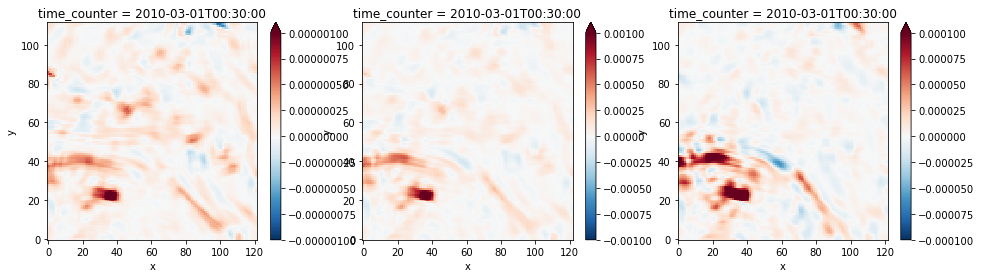

In [174]:
# fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(16,4))
# wpbpb_ML.plot(ax=ax1, vmax=1e-6)
# wptpb_ML.plot(ax=ax2, vmax=1e-3)
# wpspb_ML.plot(ax=ax3, vmax=1e-4)

Text(0, 0.5, "$\\overline{w's'}$ ($\\times 10^{-4}$) [m (g/kg) s$^{-1}$]")

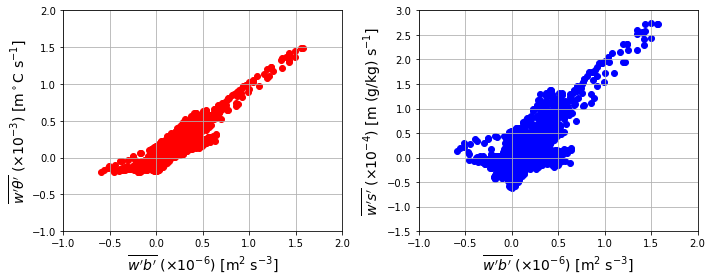

In [108]:
# fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
# fig.set_tight_layout(True)
# ax1.grid(True)
# ax2.grid(True)
# ax1.scatter(wpbpb_ML.data.ravel()*1e6, wptpb_ML.data.ravel()*1e3, c='r')
# ax2.scatter(wpbpb_ML.data.ravel()*1e6, wpspb_ML.data.ravel()*1e4, c='b')
# # ax1.set_xscale('log')
# # ax2.set_xscale('log')
# # ax1.set_yscale('log')
# # ax2.set_yscale('log')
# ax1.set_xlim([-1e0,2e0])
# ax1.set_ylim([-1e0,2e0])
# ax2.set_xlim([-1e0,2e0])
# ax2.set_ylim([-1.5e0,3e0])
# ax1.set_xlabel(r"$\overline{w'b'}$ ($\times 10^{-6}$) [m$^2$ s$^{-3}$]", fontsize=14)
# ax2.set_xlabel(r"$\overline{w'b'}$ ($\times 10^{-6}$) [m$^2$ s$^{-3}$]", fontsize=14)
# ax1.set_ylabel(r"$\overline{w'\theta'}$ ($\times 10^{-3}$) [m$^\circ$C s$^{-1}$]", fontsize=14)
# ax2.set_ylabel(r"$\overline{w's'}$ ($\times 10^{-4}$) [m (g/kg) s$^{-1}$]", fontsize=14)

In [92]:
# h = dsmask.e3w_0[0,:81].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2))
# dh = dsmask.gdepw_0[0,:81].sel(y=slice(ys+2,ye-2),x=slice(xs+2,xe-2))
# hb = ((h*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
#       / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
#      )
# dhb = ((dh*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
#        / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
#       )

bb_ML = ((bb * dsmask.e3w_1d[0,:81].data[:,np.newaxis,np.newaxis]
         ).where(bb.deptht <= MLDb).sum('deptht') 
         * MLDb**-1)
tb_ML = ((tb * dsmask.e3w_1d[0,:81].data[:,np.newaxis,np.newaxis]
         ).where(tb.deptht <= MLDb).sum('deptht') 
         * MLDb**-1)
sb_ML = ((sb * dsmask.e3w_1d[0,:81].data[:,np.newaxis,np.newaxis]
         ).where(sb.deptht <= MLDb).sum('deptht') 
         * MLDb**-1)
bb_ML

<xarray.DataArray (y: 40, x: 40)>
array([[-0.25922407, -0.25900738, -0.25895161, ..., -0.25835967,
        -0.25838749, -0.25858044],
       [-0.25938754, -0.25931744, -0.25928467, ..., -0.2588126 ,
        -0.25855102, -0.25858885],
       [-0.25947017, -0.25941097, -0.25920489, ..., -0.25875634,
        -0.25876836, -0.25860778],
       ...,
       [-0.25591099, -0.25655926, -0.25926267, ..., -0.25465548,
        -0.25476444, -0.25505884],
       [-0.25656573, -0.25566461, -0.25852497, ..., -0.25501826,
        -0.25535118, -0.25582553],
       [-0.25592021, -0.25588481, -0.2558809 , ..., -0.25647845,
        -0.2568131 , -0.2573181 ]])
Coordinates:
    time_counter  datetime64[ns] 2010-03-01T00:30:00
    deptht        (y, x) float64 201.8 227.1 227.1 244.8 ... 48.34 44.36 40.54
Dimensions without coordinates: y, x

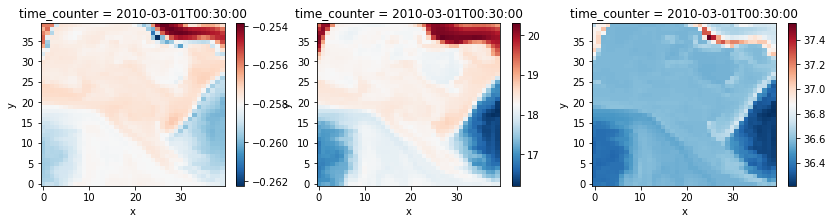

In [93]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14,3))
# fig.set_tight_layout(True)
bb_ML.plot(ax=ax1, cmap='RdBu_r')
tb_ML.plot(ax=ax2, cmap='RdBu_r')
sb_ML.plot(ax=ax3, cmap='RdBu_r')

In [105]:
(dsmask.gdepw_1d[0,:81].data[:,np.newaxis,np.newaxis])*MLDb.data**-1

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[4.95666876e-03, 4.40331568e-03, 4.40331568e-03, ...,
         6.43172441e-03, 6.14332951e-03, 7.43071487e-03],
        [5.16462066e-03, 4.95666876e-03, 4.57693148e-03, ...,
         8.23241403e-03, 3.93821443e-03, 4.57693148e-03],
        [4.95666876e-03, 

In [108]:
mu1 = xr.DataArray((2*(-dsmask.gdepw_1d[0,:81].data[:,np.newaxis,np.newaxis])*MLDb.data**-1 + 1).data, 
                   dims=bb.dims, coords=bb.coords)
mu1 = mu1.where(mu1.deptht <= MLDb)
mu = (1.-mu1**2)*(1.+5/21*mu1**2)
mu

<xarray.DataArray (deptht: 81, y: 40, x: 40)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.02433297, 0.02163766, 0.02163766, ..., 0.03149192,
         0.03009519, 0.03631905],
        [0.02534451, 0.02433297, 0.02248389, ..., 0.04018047,
         0.01936811, 0.02248389],
        [0.02433297, 0.0264206 , 0.02248389, ..., 0.01686082,
         0.01578726, 0.01631067],
        ...,
        [0.1072879 , 0.1279778 , 0.09877399, ..., 0.0639122 ,


In [131]:
Ce = 0.01
xu = dsmask.e1u.sel(y=slice(ys,ye),x=slice(xs,xe))[0,2:-2,2:-2]
yv = dsmask.e2v.sel(y=slice(ys,ye),x=slice(xs,xe))[0,2:-2,2:-2]
rAu = (dsmask.e1u * dsmask.e2u).sel(y=slice(ys,ye),x=slice(xs,xe))[0,2:-2,2:-2]
rAv = (dsmask.e1v * dsmask.e2v).sel(y=slice(ys,ye),x=slice(xs,xe))[0,2:-2,2:-2]
xb = ((xu*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
      / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
     )
yb = ((yv*At[2:-2,2:-2]).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At[2:-2,2:-2].coarsen({'y':5,'x':5}, boundary='trim').sum()
      )
Aub = ((rAu*rAu).coarsen({'y':5,'x':5}, boundary='trim').sum()
      / rAu.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )
Avb = ((rAv*rAv).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / rAv.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )

bbx = (5*xb[:,1:].data)**-1 * (bb_ML[:,1:].data-bb_ML[:,:-1])
bby = (5*yb[1:].data)**-1 * (bb_ML[1:].data-bb_ML[:-1])
bbx = ((bbx[:,1:].data*Aub[:,2:].data + bbx[:,:-1]*Aub[:,:-2].data) 
        * (Aub[:,2:].data + Aub[:,:-2].data)**-1
      )
bby = ((bby[1:].data*Avb[2:].data + bby[:-1]*Avb[:-2].data)
        * (Avb[2:].data + Avb[:-2].data)**-1
      )
gradB2 = bbx[1:-1]**2 + bby[:,1:-1]**2
gradbb2H = Ce * mu[:,1:-1,1:-1]*(gradB2 * MLDb[1:-1,1:-1]**2) * np.abs(fb[1:-1,1:-1])**-1
gradbb2H

<xarray.DataArray (deptht: 81, y: 38, x: 38)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[9.32937979e-11, 7.08078565e-11, 1.52136450e-10, ...,
         3.00866895e-11, 6.17732762e-11, 1.29534267e-10],
        [3.33283012e-11, 1.56666233e-10, 1.39600516e-10, ...,
         1.68465581e-12, 7.52634877e-

(1e-12, 1e-06)

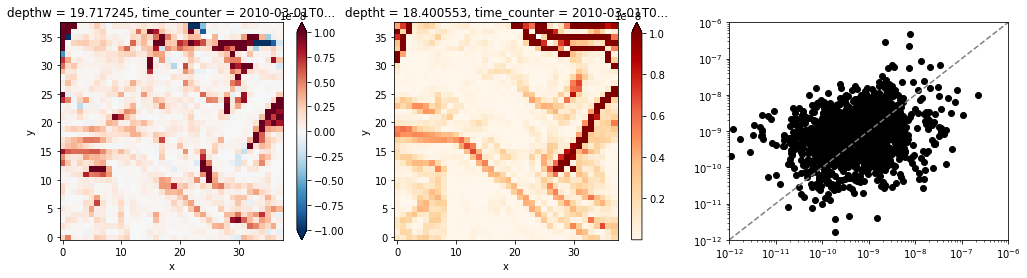

In [141]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
(wpbpb[10,1:-1,1:-1]).plot(ax=ax1, vmax=1e-8)
gradbb2H[10].plot(ax=ax2, vmax=1e-8, cmap='OrRd')
ax3.scatter(gradbb2H[10], wpbpb[10,1:-1,1:-1], c='k')
ax3.plot(np.linspace(1e-12,1e-5), np.linspace(1e-12,1e-5), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-12,1e-6])
ax3.set_xlim([1e-12,1e-6])

In [135]:
tbx = (5*xb[:,1:].data)**-1 * (tb_ML[:,1:].data-tb_ML[:,:-1])
tby = (5*yb[1:].data)**-1 * (tb_ML[1:].data-tb_ML[:-1])
tbx = ((tbx[:,1:].data*Aub[:,2:].data + tbx[:,:-1]*Aub[:,:-2].data) 
        * (Aub[:,2:].data + Aub[:,:-2].data)**-1
      )
tby = ((tby[1:].data*Avb[2:].data + tby[:-1]*Avb[:-2].data)
        * (Avb[2:].data + Avb[:-2].data)**-1
      )
gradT2 = tbx[1:-1]**2 + tby[:,1:-1]**2
gradtb2H = Ce * mu[:,1:-1,1:-1]*(gradT2 * MLDb[1:-1,1:-1]**2) * np.abs(fb[1:-1,1:-1])**-1

sbx = (5*xb[:,1:].data)**-1 * (sb_ML[:,1:].data-sb_ML[:,:-1])
sby = (5*yb[1:].data)**-1 * (sb_ML[1:].data-sb_ML[:-1])
sbx = ((sbx[:,1:].data*Aub[:,2:].data + sbx[:,:-1]*Aub[:,:-2].data) 
        * (Aub[:,2:].data + Aub[:,:-2].data)**-1
      )
sby = ((sby[1:].data*Avb[2:].data + sby[:-1]*Avb[:-2].data)
        * (Avb[2:].data + Avb[:-2].data)**-1
      )
gradS2 = sbx[1:-1]**2 + sby[:,1:-1]**2
gradsb2H = Ce * mu[:,1:-1,1:-1]*(gradS2 * MLDb[1:-1,1:-1]**2) * np.abs(fb[1:-1,1:-1])**-1

gradtb2H

<xarray.DataArray (deptht: 81, y: 38, x: 38)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[2.31575434e-05, 2.12652938e-05, 4.54508403e-05, ...,
         1.17112488e-04, 2.47607212e-04, 4.03125207e-04],
        [1.66854349e-05, 3.71767799e-05, 3.16192441e-05, ...,
         6.18451340e-04, 4.60686234e-

(1e-06, 0.1)

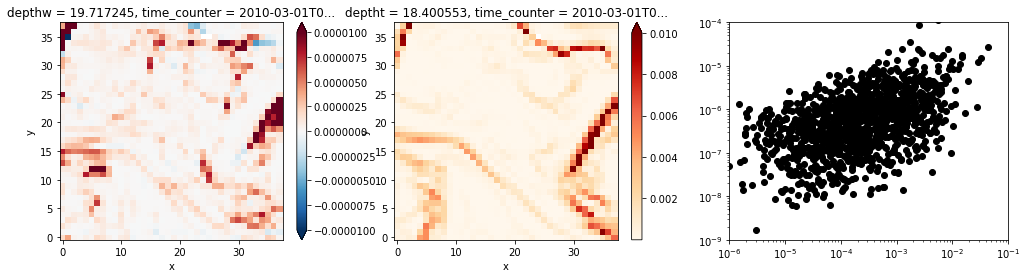

In [147]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
(wptpb[10,1:-1,1:-1]).plot(ax=ax1, vmax=1e-5)
gradtb2H[10].plot(ax=ax2, vmax=1e-2, cmap='OrRd')
ax3.scatter(gradtb2H[10], wptpb[10,1:-1,1:-1], c='k')
# ax3.plot(np.linspace(1e-12,1e-5), np.linspace(1e-12,1e-5), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-9,1e-4])
ax3.set_xlim([1e-6,1e-1])

(1e-08, 0.01)

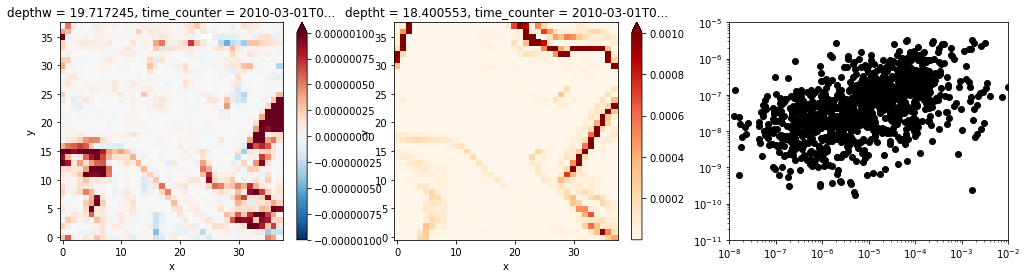

In [146]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
(wpspb[10,1:-1,1:-1]).plot(ax=ax1, vmax=1e-6)
gradsb2H[10].plot(ax=ax2, vmax=1e-3, cmap='OrRd')
ax3.scatter(gradsb2H[10], wpspb[10,1:-1,1:-1], c='k')
# ax3.plot(np.linspace(1e-12,1e-5), np.linspace(1e-12,1e-5), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-11,1e-5])
ax3.set_xlim([1e-8,1e-2])

# March 2010

In [6]:
wpCpb = xr.open_mfdataset(op.join(sdir,'wpCpb_y2010m03d*.nc'), concat_dim='time')
wpCpb

/home/uchidat/.conda/envs/natl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/uchidat/.conda/envs/natl/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:       (depthw: 80, time: 744, x: 40, y: 40)
Coordinates:
  * depthw        (depthw) float32 1.0000261 2.156828 ... 579.2115 592.83234
    time_counter  (time) datetime64[ns] 2010-03-01T00:30:00 ... 2010-03-31T23:30:00
    deptht        (time, y, x) float32 dask.array<chunksize=(1, 40, 40), meta=np.ndarray>
Dimensions without coordinates: time, x, y
Data variables:
    wpbpb         (time, depthw, y, x) float64 dask.array<chunksize=(1, 80, 40, 40), meta=np.ndarray>
    wptpb         (time, depthw, y, x) float64 dask.array<chunksize=(1, 80, 40, 40), meta=np.ndarray>
    wpspb         (time, depthw, y, x) float64 dask.array<chunksize=(1, 80, 40, 40), meta=np.ndarray>

In [7]:
# gradC2 = xr.open_mfdataset(op.join(sdir,'gradCb2-Tgrid_y2010m03d01*.nc'), concat_dim='time')
# gradC2

In [8]:
gradC2H = xr.open_mfdataset(op.join(sdir,'gradCb2-H2_y2010m03d*.nc'), concat_dim='time')
gradC2H

/home/uchidat/.conda/envs/natl/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/uchidat/.conda/envs/natl/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:       (deptht: 81, time: 744, x: 38, y: 38)
Coordinates:
  * deptht        (deptht) float32 0.48045477 1.5587916 ... 586.00415 599.69586
    time_counter  (time) datetime64[ns] 2010-03-01T00:30:00 ... 2010-03-31T23:30:00
Dimensions without coordinates: time, x, y
Data variables:
    gradB2H2      (time, deptht, y, x) float64 dask.array<chunksize=(1, 81, 38, 38), meta=np.ndarray>
    gradS2H2      (time, deptht, y, x) float64 dask.array<chunksize=(1, 81, 38, 38), meta=np.ndarray>
    gradT2H2      (time, deptht, y, x) float64 dask.array<chunksize=(1, 81, 38, 38), meta=np.ndarray>

(1e-12, 1e-06)

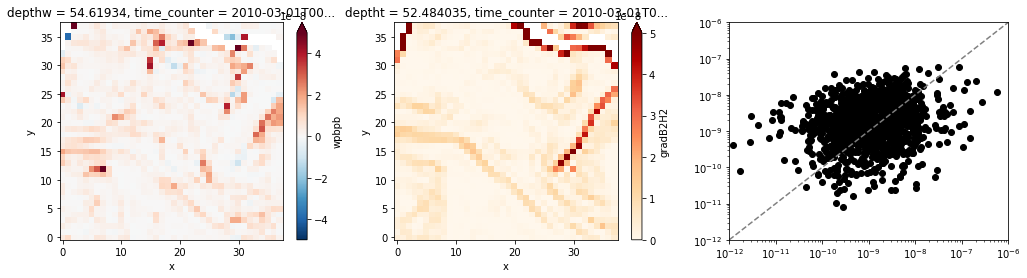

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
wpCpb.wpbpb[0,20,1:-1,1:-1].plot(ax=ax1, vmax=5e-8)
(gradC2H.gradB2H2[0,20]*1e-2).plot(ax=ax2, vmin=0., vmax=5e-8, cmap='OrRd')
ax3.scatter(gradC2H.gradB2H2[0,20]*1e-2, wpCpb.wpbpb[0,20,1:-1,1:-1], c='k')
ax3.plot(np.linspace(1e-12,1e-5), np.linspace(1e-12,1e-5), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-12,1e-6])
ax3.set_xlim([1e-12,1e-6])

(1e-12, 1e-06)

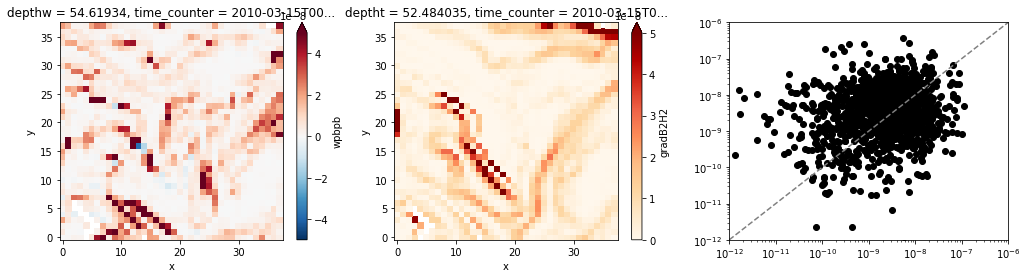

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
wpCpb.wpbpb[::24][14,20,1:-1,1:-1].plot(ax=ax1, vmax=5e-8)
(gradC2H.gradB2H2[::24][14,20]*1e-2).plot(ax=ax2, vmin=0., vmax=5e-8, cmap='OrRd')
ax3.scatter(gradC2H.gradB2H2[::24][14,20]*1e-2, wpCpb.wpbpb[::24][14,20,1:-1,1:-1], c='k')
ax3.plot(np.linspace(1e-12,1e-5), np.linspace(1e-12,1e-5), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-12,1e-6])
ax3.set_xlim([1e-12,1e-6])

In [21]:
alpha = 4e-5
beta = 7.9e-4
with ProgressBar():
    wpbp_lin = g*(alpha*wpCpb.wptpb - beta*wpCpb.wpspb)[::24,::2].compute()
wpbp_lin

[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  0.3s


<xarray.DataArray (time: 31, depthw: 40, y: 40, x: 40)>
array([[[[-1.26027616e-10, -8.24602457e-11, -1.63658854e-10, ...,
           1.67320813e-11,  1.26361830e-11,  6.05685643e-12],
         [-3.02739325e-11, -7.81181262e-11, -1.69691787e-10, ...,
          -1.25650678e-10, -3.57889761e-13, -1.60899481e-11],
         [-4.88158762e-11, -7.95787040e-12,  3.57696939e-12, ...,
           6.90080812e-11,  7.29224526e-11, -3.29515256e-11],
         ...,
         [ 5.03265492e-11,  6.77454457e-10,  2.50774701e-09, ...,
           8.03162888e-12, -1.51601639e-11,  6.91377690e-12],
         [ 7.09595926e-11,  7.67702924e-11,  1.96920780e-09, ...,
           9.65435651e-12, -6.39256128e-12, -1.22802192e-12],
         [ 1.46092758e-11,  4.73686669e-11,  2.01782899e-10, ...,
          -4.37649007e-12, -1.54049898e-11, -1.59505429e-11]],

        [[-4.36274302e-10, -2.85529053e-10, -5.66591751e-10, ...,
           5.79900337e-11,  4.38415845e-11,  2.16130291e-11],
         [-1.04585294e-10, -2.70

Text(0, 0.5, "$\\overline{w's'}^{xy}$ ($\\times 10^{-5}$) [m (g/kg) s$^{-1}$]")

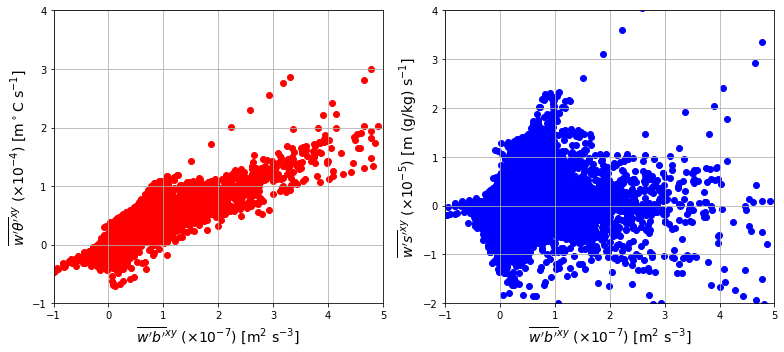

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
fig.set_tight_layout(True)
ax1.grid(True)
ax2.grid(True)
# ax3.grid(True)
ax1.scatter(wpCpb.wpbpb[::24,::2]*1e7, wpCpb.wptpb[::24,::2]*1e4, 
            c='r')
ax2.scatter(wpCpb.wpbpb[::24,::2]*1e7, wpCpb.wpspb[::24,::2]*1e5, 
            c='b')
# ax3.scatter(wpCpb.wpbpb[::24,::2]*1e7, wpbp_lin*1e7, 
#             c='k')
ax1.set_xlim([-1e0,5e0])
ax1.set_ylim([-1e0,4e0])
ax2.set_xlim([-1e0,5e0])
ax2.set_ylim([-2e0,4e0])
# ax3.set_xlim([-1e0,5e0])
# ax3.set_ylim([-4e0,3e0])
ax1.set_xlabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax2.set_xlabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax1.set_ylabel(r"$\overline{w'\theta'}^{xy}$ ($\times 10^{-4}$) [m$^\circ$C s$^{-1}$]", fontsize=14)
ax2.set_ylabel(r"$\overline{w's'}^{xy}$ ($\times 10^{-5}$) [m (g/kg) s$^{-1}$]", fontsize=14)
# ax3.set_xlabel(r"$\overline{w'b'}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
# ax3.set_ylabel(r"$g(\alpha\overline{w'\theta'}^{xy}-\beta\overline{w's'}^{xy})$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", 
#                fontsize=14)

Text(0.5, 0, '$H_{\\tt ML}^2|\\nabla_{\\tt H}\\overline{s}^{xyz}|^2 / f$ [(g/kg)$^2$ s]')

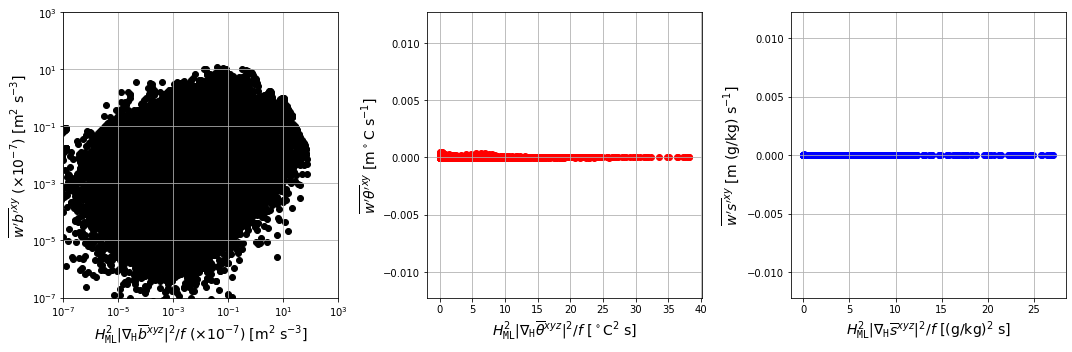

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
fig.set_tight_layout(True)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax1.scatter(1e-2*gradC2H.gradB2H2[::24,1::2]*1e7,
            wpCpb.wpbpb[::24,::2,1:-1,1:-1]*1e7, 
            c='k')
ax2.scatter(gradC2H.gradT2H2[::24,1::2], 
            wpCpb.wptpb[::24,::2,1:-1,1:-1],
            c='r')
ax3.scatter(gradC2H.gradS2H2[::24,1::2], 
            wpCpb.wpspb[::24,::2,1:-1,1:-1], 
            c='b')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim([1e-7,1e3])
ax1.set_xlim([1e-7,1e3])
ax1.set_ylabel(r"$\overline{w'b'}^{xy}$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", fontsize=14)
ax2.set_ylabel(r"$\overline{w'\theta'}^{xy}$ [m$^\circ$C s$^{-1}$]", fontsize=14)
ax3.set_ylabel(r"$\overline{w's'}^{xy}$ [m (g/kg) s$^{-1}$]", fontsize=14)
ax1.set_xlabel(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2 / f$ ($\times 10^{-7}$) [m$^2$ s$^{-3}$]", 
               fontsize=14)
ax2.set_xlabel(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{\theta}^{xyz}|^2 / f$ [$^\circ$C$^2$ s]", fontsize=14)
ax3.set_xlabel(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{s}^{xyz}|^2 / f$ [(g/kg)$^2$ s]", fontsize=14)